In [316]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score

from sklearn.model_selection import train_test_split

In [317]:
DATA_PATH = './Data/'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')
submission_df = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [318]:
train_df.head(30)

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
7,TRAIN_0000007,rih[.]p[.]se,0
8,TRAIN_0000008,microsoft[.]ltda,0
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1


In [319]:
test_df.head()

,ID,URL
0,TEST_0000000,niquelarte[.]blogspot[.]com[.]es
1,TEST_0000001,northernmetalproducts[.]com
2,TEST_0000002,ga[.]de
3,TEST_0000003,florawww[.]eeb[.]uconn[.]edu/199300089[.]html
4,TEST_0000004,activecity[.]moscow


In [320]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB


In [321]:
train_df[train_df['URL'].isna()]

,ID,URL,label


In [322]:
train_df[train_df['label'].isna()]

,ID,URL,label


C:\Users\이민하\AppData\Local\Temp\ipykernel_18368\1986079669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = train_df['label'].value_counts().index,


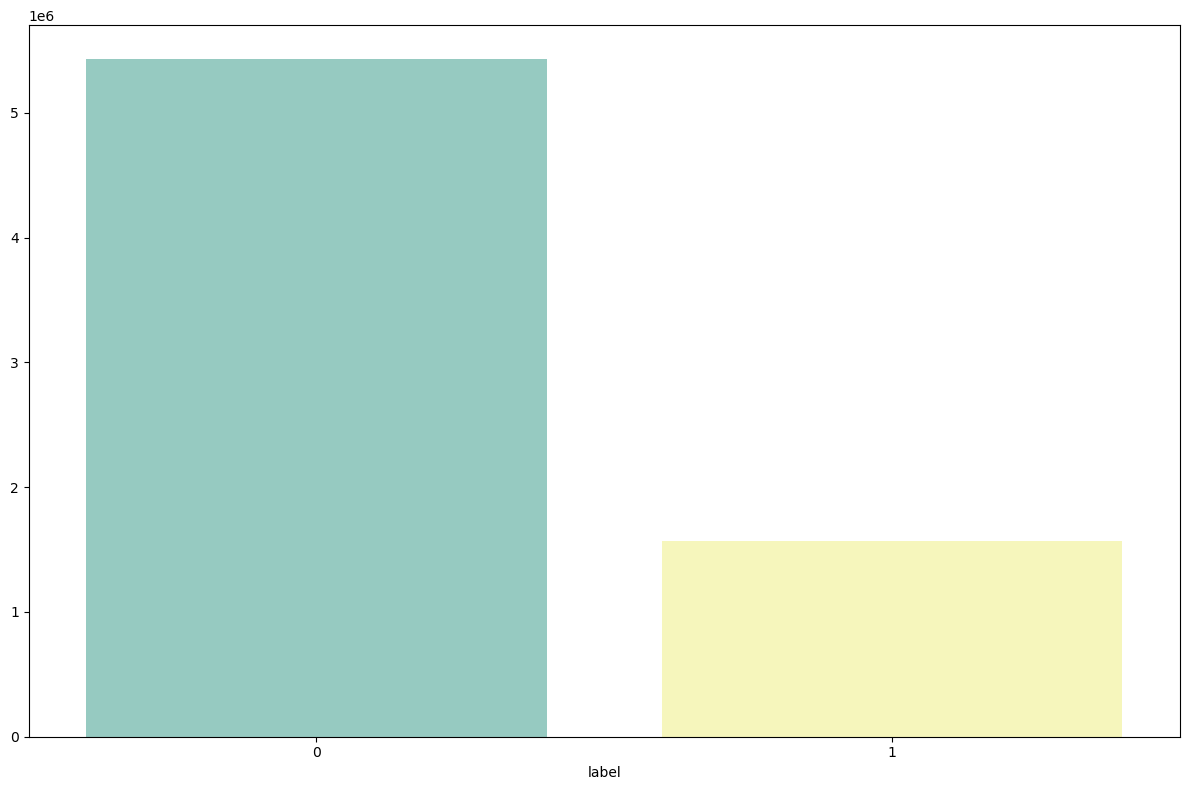

In [323]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(x = train_df['label'].value_counts().index,
            y = train_df['label'].value_counts().values,
            palette = 'Set3',
            ax = ax)
plt.tight_layout()
plt.show()

In [324]:
train_df[train_df['label'] == 1]

,ID,URL,label
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1
12,TRAIN_0000012,apollo[.]baby,1
...,...,...,...
6995033,TRAIN_6995033,posts-8012419782[.]smarttechno[.]hr,1
6995044,TRAIN_6995044,rthe[.]top/,1
6995047,TRAIN_6995047,www2[.]ml[.]meiceaord[.]com,1
6995050,TRAIN_6995050,10rtggdoffice[.]duckdns[.]org,1


In [325]:
train_df['URL'] = train_df['URL'].apply(lambda x: x.replace('[.]', '.'))
test_df['URL'] = test_df['URL'].apply(lambda x: x.replace('[.]', '.'))

In [326]:
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

In [327]:
train_df[train_df['label'] == 1]['length'].value_counts()

length
23      55904
22      48499
29      47146
28      47104
27      45781
        ...  
731         1
4266        1
744         1
814         1
617         1
Name: count, Length: 1085, dtype: int64

In [328]:
train_df[train_df['label'] == 0]['length'].value_counts()

length
14     386560
15     379486
13     376940
16     361308
12     354793
        ...  
339         1
440         1
237         1
297         1
475         1
Name: count, Length: 439, dtype: int64

In [329]:
train_df[train_df['label'] == 1]['length'].value_counts().sort_index()

length
2         1
3         2
4        11
5        59
6       327
       ... 
6089      1
7990      1
8118      1
8250      1
8394      1
Name: count, Length: 1085, dtype: int64

In [330]:
train_df.corr(numeric_only = True)

,label,length,subdomain_count,special_char_count
label,1.000000,0.326656,0.350023,0.356997
length,0.326656,1.000000,0.468284,0.748222
subdomain_count,0.350023,0.468284,1.000000,0.445515
special_char_count,0.356997,0.748222,0.445515,1.000000


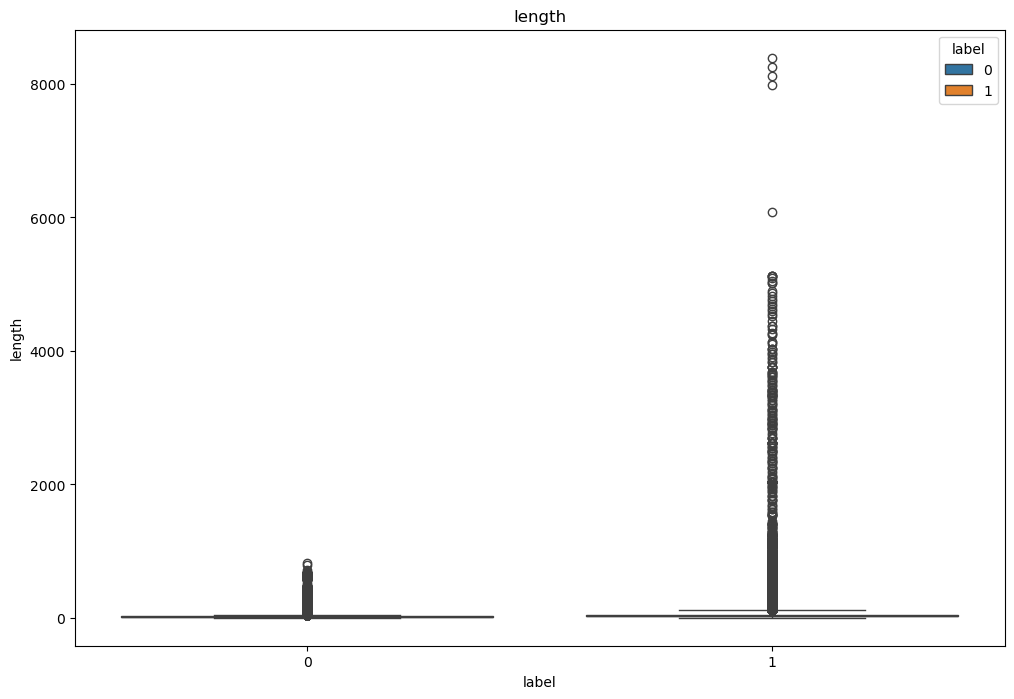

length의 label 0 이상치 개수: 32830
length의 label 1 이상치 개수: 257040


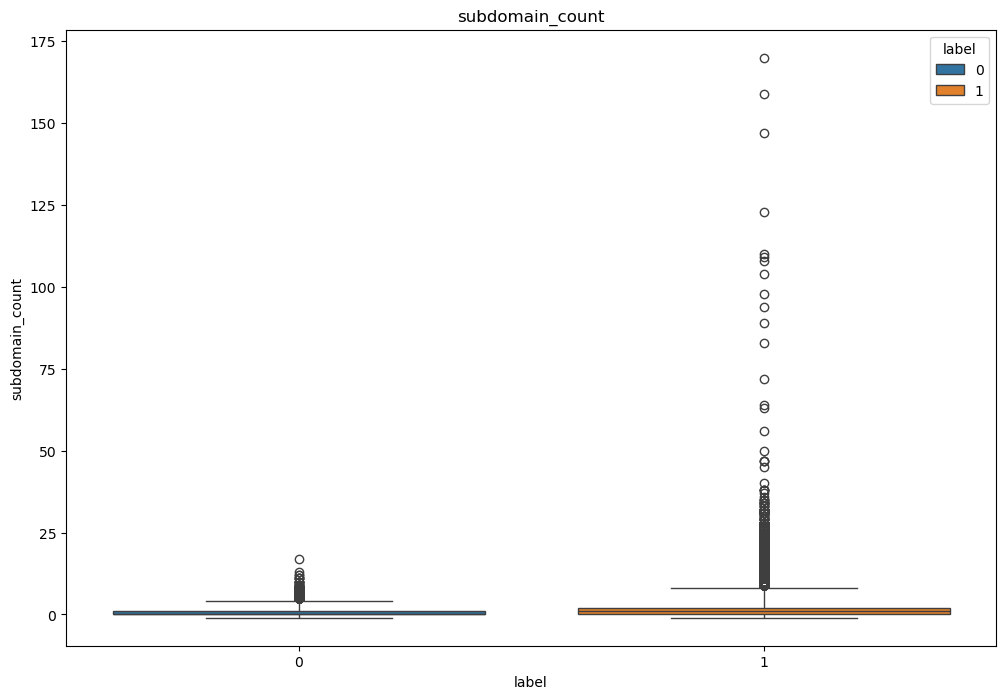

subdomain_count의 label 0 이상치 개수: 1116
subdomain_count의 label 1 이상치 개수: 40407


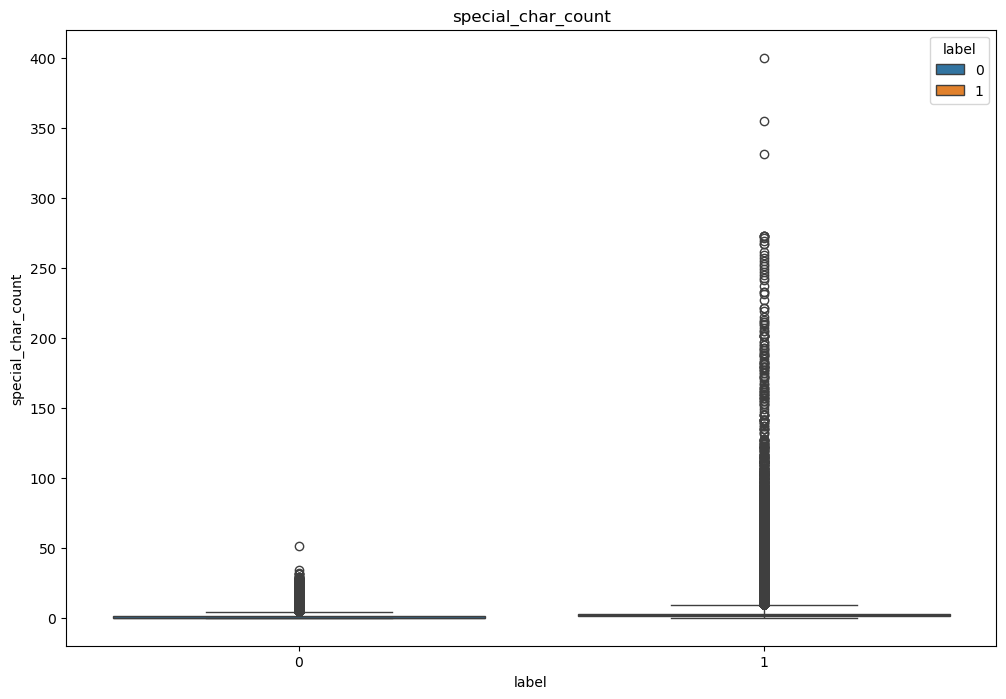

special_char_count의 label 0 이상치 개수: 71427
special_char_count의 label 1 이상치 개수: 192994


In [331]:
columns = ['length', 'subdomain_count', 'special_char_count']

for col in columns:
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.boxplot(data = train_df, x = 'label', y = col, hue = 'label', whis = 3)
    plt.title(col)
    plt.show()

    q1 = train_df[col].quantile(0.25)  # 1분위수 (25%)
    q3 = train_df[col].quantile(0.75)  # 3분위수 (75%)
    iqr = q3 - q1  # IQR 계산

    # 이상치 기준: IQR 범위를 벗어나는 값
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr

    # 이상치 확인
    outliers_0 = train_df[((train_df[col] < lower_bound) | (train_df[col] > upper_bound)) & (train_df['label'] == 0)]
    outliers_1 = train_df[((train_df[col] < lower_bound) | (train_df[col] > upper_bound)) & (train_df['label'] == 1)]
   
    print(f"{col}의 label 0 이상치 개수: {outliers_0.shape[0]}")
    print(f"{col}의 label 1 이상치 개수: {outliers_1.shape[0]}")

In [332]:
def tokenize_url(url):
    tokens = re.split(r'[\W_]+', url)
    return [token.lower() for token in tokens if token]

train_url = train_df['URL']
train_url = [tokenize_url(url) for url in train_url]

test_url = test_df['URL']
test_url = [tokenize_url(url) for url in test_url]

train_url

[['poznan', 'wuoz', 'gov', 'pl'],
 ['vill', 'okawa', 'kochi', 'jp'],
 ['nationalfinance', 'co', 'om'],
 ['town', 'ozora', 'hokkaido', 'jp'],
 ['open24', 'ie', 'news', 'irish', 'online', 'login'],
 ['93fm', 'radio', 'br', 'file'],
 ['ps', 'com', 'vu', 'wp', 'config', 'wp', 'incluides', 'soft', 'ursnbxmmvd'],
 ['rih', 'p', 'se'],
 ['microsoft', 'ltda'],
 ['165', '232', '173', '145', 'mobile', 'html'],
 ['www', 'vanylven', 'no'],
 ['pref', 'kagawa', 'jp'],
 ['apollo', 'baby'],
 ['adonis', 'holdings'],
 ['jalawave', 'net', 'id'],
 ['hiroshima', 'jp'],
 ['town', 'hiroo', 'hokkaido', 'jp'],
 ['nic', 'weather'],
 ['nsa', 'community'],
 ['allegro', 'tm', 'pl'],
 ['championsleague', 'basketball'],
 ['cmsjm', 'rj', 'gov', 'br'],
 ['wcape', 'school', 'za'],
 ['town', 'yugawara', 'kanagawa', 'jp'],
 ['global', 'net', 'pg', 'diocese', 'of', 'aitape', 'aitape', 'htm'],
 ['vill', 'ogimi', 'okinawa', 'jp'],
 ['oldham', 'sch', 'uk'],
 ['city', 'makinohara', 'shizuoka', 'jp'],
 ['kagoshima', 'jp'],
 ['v

In [333]:
token_freqs = {}

for token_list in train_url:
    for token in token_list:
        if token.isnumeric():
            token = '<num>'   
             
        if token not in token_freqs:
            token_freqs[token] = 1
        else:
            token_freqs[token] += 1


In [334]:
token_freqs

{'poznan': 290,
 'wuoz': 3,
 'gov': 51369,
 'pl': 73492,
 'vill': 157,
 'okawa': 13,
 'kochi': 124,
 'jp': 125717,
 'nationalfinance': 3,
 'co': 353615,
 'om': 545,
 'town': 1442,
 'ozora': 8,
 'hokkaido': 398,
 'open24': 33,
 'ie': 10056,
 'news': 12865,
 'irish': 216,
 'online': 39873,
 'login': 116843,
 '93fm': 4,
 'radio': 1352,
 'br': 56052,
 'file': 4950,
 'ps': 2080,
 'com': 3510256,
 'vu': 5119,
 'wp': 52327,
 'config': 647,
 'incluides': 1,
 'soft': 1269,
 'ursnbxmmvd': 1,
 'rih': 10,
 'p': 9359,
 'se': 21756,
 'microsoft': 3152,
 'ltda': 41,
 '<num>': 639210,
 'mobile': 7723,
 'html': 297821,
 'www': 199880,
 'vanylven': 3,
 'no': 13874,
 'pref': 503,
 'kagawa': 65,
 'apollo': 140,
 'baby': 464,
 'adonis': 22,
 'holdings': 132,
 'jalawave': 2,
 'net': 327114,
 'id': 75689,
 'hiroshima': 245,
 'hiroo': 4,
 'nic': 3017,
 'weather': 523,
 'nsa': 60,
 'community': 2059,
 'allegro': 1116,
 'tm': 722,
 'championsleague': 2,
 'basketball': 1515,
 'cmsjm': 2,
 'rj': 2324,
 'wcape': 6

In [335]:
sorted_tokens = sorted(token_freqs.items(), key = lambda x: x[1], reverse = True)
sorted_tokens

[('com', 3510256),
 ('<num>', 639210),
 ('org', 582407),
 ('co', 353615),
 ('net', 327114),
 ('de', 316033),
 ('html', 297821),
 ('uk', 256487),
 ('php', 237533),
 ('ru', 205323),
 ('www', 199880),
 ('index', 137759),
 ('jp', 125717),
 ('htm', 124066),
 ('edu', 121026),
 ('login', 116843),
 ('files', 110393),
 ('it', 105001),
 ('fr', 83822),
 ('au', 78511),
 ('id', 75689),
 ('ca', 75300),
 ('pl', 73492),
 ('nl', 72149),
 ('cn', 69094),
 ('info', 67626),
 ('app', 61079),
 ('top', 57934),
 ('us', 57744),
 ('br', 56052),
 ('wp', 52327),
 ('duckdns', 51839),
 ('in', 51604),
 ('gov', 51369),
 ('web', 49379),
 ('amp', 47397),
 ('xyz', 45389),
 ('ch', 43855),
 ('geocities', 42429),
 ('online', 39873),
 ('home', 35556),
 ('es', 34866),
 ('000webhostapp', 34600),
 ('tr', 32469),
 ('en', 31249),
 ('tripod', 31126),
 ('blogspot', 30689),
 ('io', 30141),
 ('ac', 29701),
 ('email', 29664),
 ('ua', 29650),
 ('dk', 29494),
 ('eu', 28453),
 ('at', 26707),
 ('content', 26571),
 ('cz', 26215),
 ('be', 2

In [336]:
PAD_TOKEN, OOV_TOKEN = '<pad>', '<oov>'

vocab = {PAD_TOKEN : 0, OOV_TOKEN : 1}

for index, token in enumerate(sorted_tokens, 2):
    vocab[token[0]] = index
    if index >= 10000:
        break

In [337]:
len(vocab)

10001

In [338]:
vocab

{'<pad>': 0,
 '<oov>': 1,
 'com': 2,
 '<num>': 3,
 'org': 4,
 'co': 5,
 'net': 6,
 'de': 7,
 'html': 8,
 'uk': 9,
 'php': 10,
 'ru': 11,
 'www': 12,
 'index': 13,
 'jp': 14,
 'htm': 15,
 'edu': 16,
 'login': 17,
 'files': 18,
 'it': 19,
 'fr': 20,
 'au': 21,
 'id': 22,
 'ca': 23,
 'pl': 24,
 'nl': 25,
 'cn': 26,
 'info': 27,
 'app': 28,
 'top': 29,
 'us': 30,
 'br': 31,
 'wp': 32,
 'duckdns': 33,
 'in': 34,
 'gov': 35,
 'web': 36,
 'amp': 37,
 'xyz': 38,
 'ch': 39,
 'geocities': 40,
 'online': 41,
 'home': 42,
 'es': 43,
 '000webhostapp': 44,
 'tr': 45,
 'en': 46,
 'tripod': 47,
 'blogspot': 48,
 'io': 49,
 'ac': 50,
 'email': 51,
 'ua': 52,
 'dk': 53,
 'eu': 54,
 'at': 55,
 'content': 56,
 'cz': 57,
 'be': 58,
 'me': 59,
 'secure': 60,
 'mail': 61,
 'r': 62,
 'club': 63,
 'cmd': 64,
 'se': 65,
 'nz': 66,
 'tk': 67,
 'free': 68,
 'admin': 69,
 'site': 70,
 'ro': 71,
 'ir': 72,
 'biz': 73,
 'sign': 74,
 'appspot': 75,
 'm': 76,
 'page': 77,
 'x': 78,
 'paypal': 79,
 'account': 80,
 'my'

In [339]:
def digit_encoder(url_list):
    for token_list in url_list:
        i = 0
        for token in token_list:
            if token in vocab:
                token_list[i] = vocab[token]
                i += 1
            else:
                token_list[i] = vocab[OOV_TOKEN]
                i += 1

In [340]:
digit_encoder(train_url)
digit_encoder(test_url)

train_url[:10]

[[3440, 1, 35, 24],
 [6023, 1, 7428, 14],
 [1, 5, 1953],
 [858, 1, 2604, 14],
 [1, 147, 121, 4485, 41, 17],
 [1, 902, 31, 292],
 [638, 2, 281, 32, 1661, 32, 1, 944, 1],
 [1, 159, 65],
 [436, 1],
 [1, 1, 1, 1, 194, 8]]

In [341]:
test_url[:10]

[[1, 48, 2, 43],
 [1, 2],
 [101, 7],
 [1612, 1530, 948, 16, 1, 8],
 [1, 2930],
 [1, 11],
 [121, 421, 5, 9, 1, 464, 278, 2525, 1, 609],
 [1, 4],
 [1, 2],
 [1, 2, 182]]

In [342]:
train_df['length'].describe()

count    6.995056e+06
mean     2.431589e+01
std      3.463807e+01
min      2.000000e+00
25%      1.300000e+01
50%      1.800000e+01
75%      2.500000e+01
max      8.394000e+03
Name: length, dtype: float64

In [343]:
test_df['length'].describe()

count    1.747689e+06
mean     2.429664e+01
std      3.417552e+01
min      2.000000e+00
25%      1.300000e+01
50%      1.800000e+01
75%      2.500000e+01
max      5.787000e+03
Name: length, dtype: float64

In [344]:
train_df[train_df['length'] == train_df['length'].max()]    


,ID,URL,label,length,subdomain_count,special_char_count
6415329,TRAIN_6415329,supportservisc.info/login/?token=jnlZLpBndnoNs...,1,8394,0,2


In [345]:
test_df[test_df['length'] == test_df['length'].max()]


,ID,URL,length,subdomain_count,special_char_count
852844,TEST_0852844,b4e921f0.sso-mailsrvr-4344e5teed.pages.dev/sup...,5787,4,4


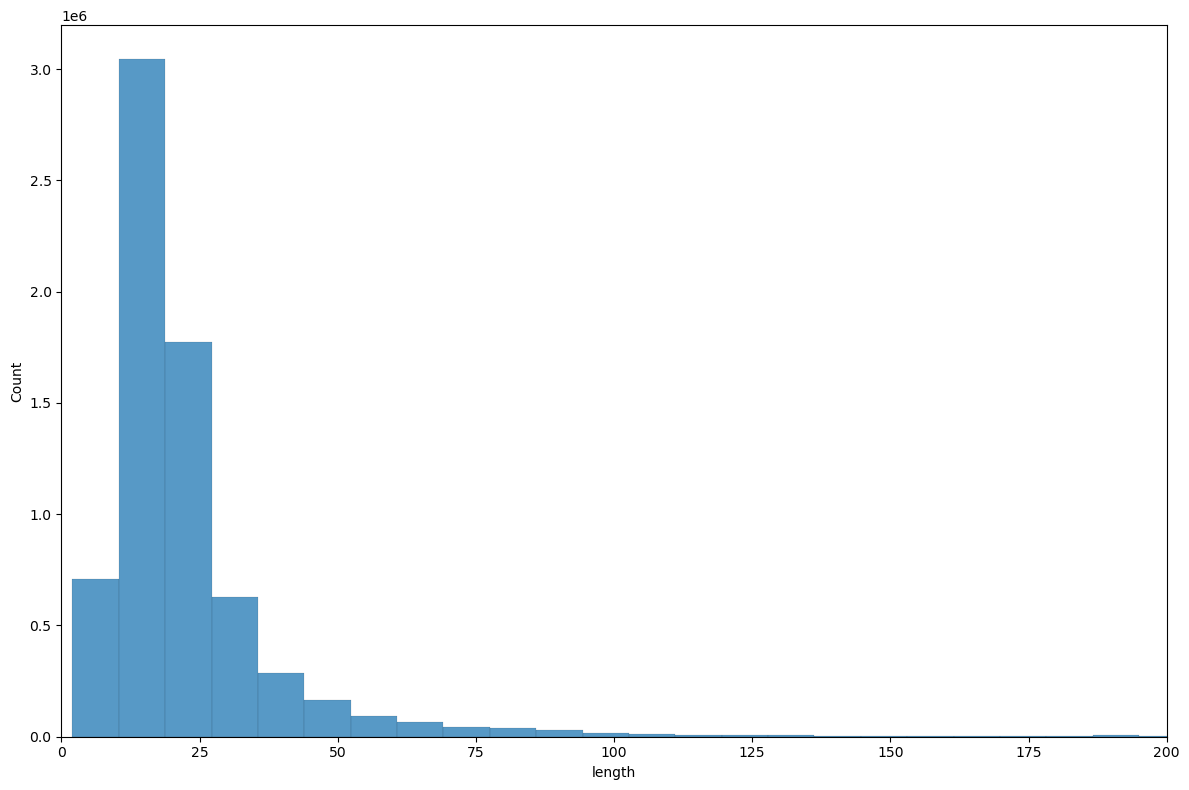

In [346]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(data = train_df,
             x = 'length',
             bins = 1000)

plt.xlim(0, 200)
plt.tight_layout()
plt.show()

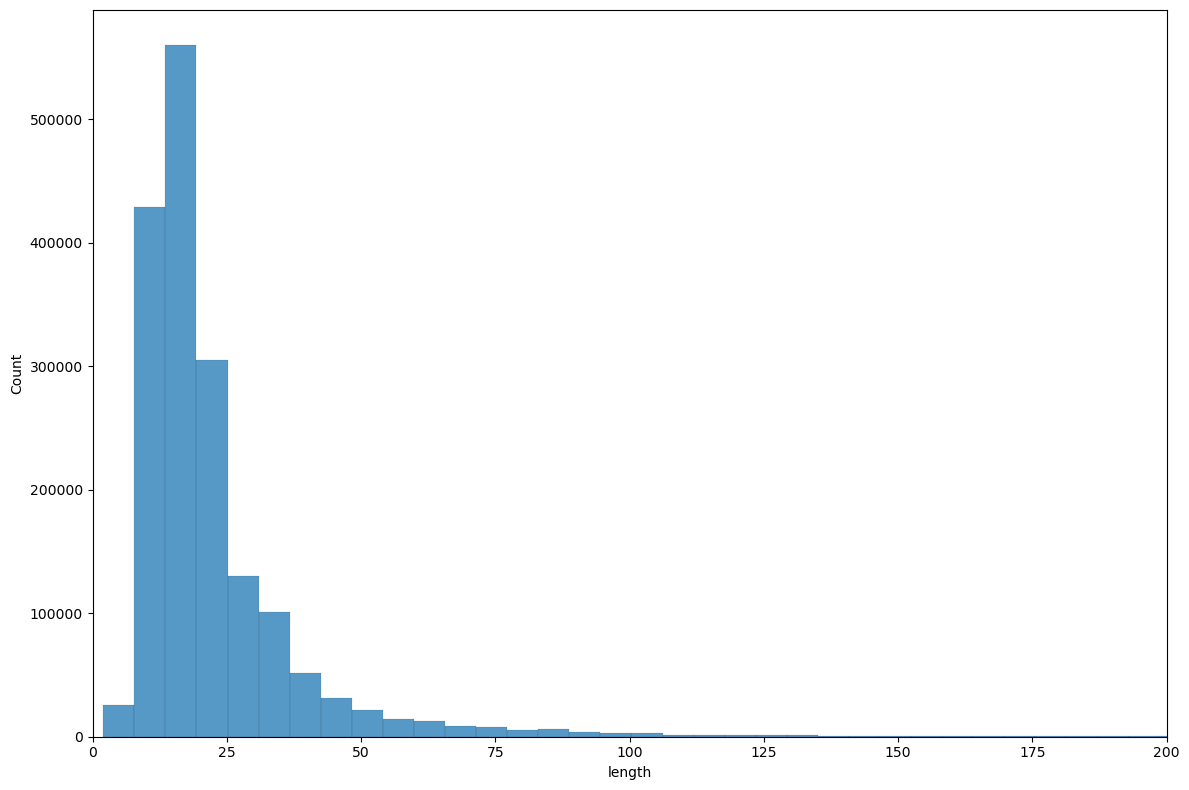

In [347]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(data = test_df,
             x = 'length',
             bins = 1000)

plt.xlim(0, 200)
plt.tight_layout()
plt.show()

In [348]:
MAX_LENGTH = 50

def padding(data_ids):
    for index, data in enumerate(data_ids):
        current_length = len(data)
        if current_length < MAX_LENGTH:
            data_ids[index] = data + ([vocab[PAD_TOKEN]] * (MAX_LENGTH - current_length))
        else:
            data_ids[index] = data[ : MAX_LENGTH]

In [349]:
padding(train_url)
padding(test_url)

In [350]:
for data in train_url[:5]:
    print(len(data), data)

print()

for data in test_url[:5]:
    print(len(data), data)

50 [3440, 1, 35, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [6023, 1, 7428, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [1, 5, 1953, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [858, 1, 2604, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [1, 147, 121, 4485, 41, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

50 [1, 48, 2, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [351]:
class TextDataset(Dataset):
    def __init__(self, df):
        self.url = df["URL"].values  # 정수 리스트
        self.length = df["length"].values.reshape(-1, 1)  # 길이 변수
        self.subdomain = df["subdomain_count"].values.reshape(-1, 1)
        self.special_char = df["special_char_count"].values.reshape(-1, 1)  # 특수문자 개수
        self.label = df["label"].values

    def __len__(self):
        return len(self.url)
    
    def __getitem__(self, index):
        return (torch.tensor(self.url[index], dtype = torch.long),
                torch.tensor(self.length[index], dtype = torch.float),
                torch.tensor(self.subdomain[index], dtype = torch.float),
                torch.tensor(self.special_char[index], dtype = torch.float),
                torch.tensor(self.label[index], dtype = torch.long))

In [352]:
train_df['URL'] = train_url
test_df['URL'] = test_url

In [353]:
train_df

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,"[3440, 1, 35, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0,18,2,0
1,TRAIN_0000001,"[6023, 1, 7428, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,19,2,0
2,TRAIN_0000002,"[1, 5, 1953, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,21,1,0
3,TRAIN_0000003,"[858, 1, 2604, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,22,2,0
4,TRAIN_0000004,"[1, 147, 121, 4485, 41, 17, 0, 0, 0, 0, 0, 0, ...",1,33,1,3
...,...,...,...,...,...,...
6995051,TRAIN_6995051,"[1, 5, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0,10,1,0
6995052,TRAIN_6995052,"[12, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,20,1,0
6995053,TRAIN_6995053,"[1, 44, 2, 7605, 7605, 0, 0, 0, 0, 0, 0, 0, 0,...",1,50,1,2
6995054,TRAIN_6995054,"[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,14,0,0


In [354]:
train_df, test_df = train_test_split(
                                    train_df,
                                    test_size = 0.2, 
                                    random_state = 7
                                )

train_dataset = TextDataset(train_df)
test_dataset = TextDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [355]:
class URLClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout, bidirectional, feature_input, feature_output):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        
        self.lstm = nn.LSTM(
            input_size = embedding_dim,
            hidden_size = hidden_dim,
            num_layers = n_layers, 
            dropout = dropout,
            bidirectional = bidirectional, 
            batch_first = True
        )

        self.fc_feature = nn.Linear(feature_input, feature_output)

        if bidirectional:
            self.fc_final = nn.Linear((hidden_dim * 2) + feature_output, 1)

        else:
            self.fc_final = nn.Linear(hidden_dim + feature_output, 1)

    def forward(self, url, length, subdomain, special_char):
        embedded_url = self.embedding(url)
        h_n, _ = self.lstm(embedded_url)
        last_lstm = h_n[:, -1, :]

        features = torch.cat((length, subdomain, special_char), dim = 1)
        features = self.fc_feature(features)

        last_features = torch.cat((last_lstm, features), dim = 1)
        output = self.fc_final(last_features)

        return output


In [356]:
vocab_size = 10000
embedding_dim = 16
hidden_dim = 32
n_layers = 2
dropout = 0.2
bidirectional = True
feature_input = 3
feature_output = 8

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = URLClassifier(vocab_size, embedding_dim, hidden_dim, 
                      n_layers, dropout, bidirectional, feature_input, feature_output).to(DEVICE)

EPOCH = 100
LR = 0.001

BCEloss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = LR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 10, verbose = True)


c:\Program Files\anaconda3\envs\Project_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [357]:
def testing(test_loader):
    model.eval()
    test_loss, test_f1 = 0, 0

    with torch.no_grad():
        for url, length, subdomain, special_char, label in test_loader:
            pre_y = model(url, length, subdomain, special_char)
            label = label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, label)
            test_loss += loss.item()

            score = BinaryF1Score()(pre_y, label)
            test_f1 += score.item()
        
    avg_test_loss = test_loss / len(test_loader)
    avg_test_f1 = test_f1 / len(test_loader)

    return avg_test_loss, avg_test_f1

In [358]:
SAVE_PATH = './saved_models/'
os.makedirs(SAVE_PATH, exist_ok = True)

def training(train_loader, test_loader):
    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    LIMIT_VALUE = 10

    LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    for epoch in range(EPOCH):
        SAVE_MODEL = os.path.join(SAVE_PATH, f'model_{epoch}.pth')
        SAVE_FILE = os.path.join(SAVE_PATH, f'model_weights_{epoch}.pth')

        loss_total, score_total = 0, 0

        for url, length, subdomain, special_char, label in train_loader:
            pre_y = model(url, length, subdomain, special_char)
            label = label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, label)
            loss_total += loss.item()

            score = BinaryF1Score()(pre_y, label)
            
            score_total += score.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        test_loss, test_f1 = testing(test_loader)
        
        LOSS_HISTORY[1].append(test_loss)
        SCORE_HISTORY[1].append(test_f1)

        LOSS_HISTORY[0].append(loss_total / len(train_loader))
        SCORE_HISTORY[0].append(score_total / len(train_loader))

        print(f"[{epoch + 1}/{EPOCH}]\n - TRAIN LOSS : {LOSS_HISTORY[0][-1]} TRAIN F1 : {SCORE_HISTORY[0][-1]}")
        print(f"- TEST LOSS : {LOSS_HISTORY[1][-1]} TEST F1 : {SCORE_HISTORY[1][-1]}")

        scheduler.step(test_f1)

            # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
        # Score 기준
        if len(SCORE_HISTORY[1]) >= 2:
            if SCORE_HISTORY[1][-1] >= SCORE_HISTORY[1][-2]: BREAK_CNT_SCORE += 1

        # 성능이 좋은 학습 가중치 저장

        if len(SCORE_HISTORY[1]) == 1:
            # 첫 번째라서 무조건 모델 파라미터 저장
            torch.save(model.state_dict(), SAVE_FILE)

        else:
            if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]):
                torch.save(model.state_dict(), SAVE_FILE)

        if BREAK_CNT_LOSS > LIMIT_VALUE:
            print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
            break

    return LOSS_HISTORY, SCORE_HISTORY


In [359]:
loss, f1 = training(train_loader, test_loader)

[1/100]
 - TRAIN LOSS : 0.2594040873373366 TRAIN F1 : 0.6667043209286907
- TEST LOSS : 0.1598738945130298 TEST F1 : 0.8362556208391557


KeyboardInterrupt: 

In [227]:
for url, length, subdomain, special_char, label in train_loader:
    print(url.max().item())  # 🔥 url 데이터의 최대값 확인
    break  # 한 배치만 확인


5267


In [271]:
print("최대값:", max([max(seq) for seq in train_dataset.url]))
print("최소값:", min([min(seq) for seq in train_dataset.url if len(seq) > 0]))


최대값: 10000
최소값: 0
